In [1]:
import numpy as np
import pandas as pd
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy
import sys
%matplotlib inline

In [2]:
!wget https://zenodo.org/record/3239543/files/mnist_c.zip
!unzip -qq mnist_c.zip
!rm mnist_c.zip

--2022-05-01 01:48:20--  https://zenodo.org/record/3239543/files/mnist_c.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246661575 (235M) [application/octet-stream]
Saving to: ‘mnist_c.zip’

mnist_c.zip         100%[===================>] 235.23M  26.8MB/s    in 9.4s    

2022-05-01 01:48:31 (25.1 MB/s) - ‘mnist_c.zip’ saved [246661575/246661575]



In [3]:
n_epochs = 8
num_classes = 10
batch_size_train = 128
batch_size_test = 128
lr = 1e-3
momentum = 0.9
wd = 1e-6
model_name = "vgg16"
size=48 if model_name == "vgg16" else None

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
def get_train_transforms(pixel_mean, pixel_std, size=None):
    if size == None:
        return transforms.Compose([
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(pixel_mean, pixel_std)
            ])
    else:
        return transforms.Compose([
            transforms.Resize(size),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(pixel_mean, pixel_std)
            ])

def get_val_transforms(pixel_mean, pixel_std,size=None):
    if size == None:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(pixel_mean, pixel_std)
            ])
    else:
        return transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(pixel_mean, pixel_std)
            ])

In [5]:
train_dataset = datasets.MNIST('', train=True, download=True, transform= get_train_transforms((0.1307,), (0.3081,), size))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
val_dataset = datasets.MNIST(root='', train=False, download=True, transform=get_val_transforms((0.1307,), (0.3081,), size))

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train, shuffle=True)

In [8]:
print(len(train_loader))
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

469


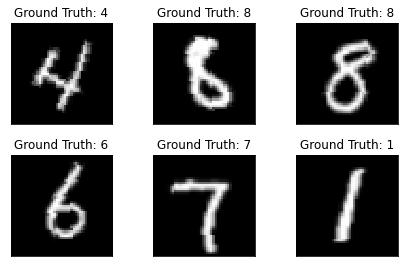

In [9]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [10]:
def preprocess_test(data, mean, std, size=None):
    N, H, W, C = data.shape
    if size==None:
        Y = torch.zeros(N, C, H, W)
        transform_test = get_val_transforms((0.1307,), (0.3081,), size)
    else:  
        Y = torch.zeros(N, C, size, size)
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    for n in range(len(data)):
        Y[n] =  transform_test(data[n])
        
    return Y

In [11]:
chal_data = np.load('mnist_c/' + 'translate/' + 'test_images.npy')
chal_data = preprocess_test(chal_data, (0.1307,), (0.3081,), size)
chal_labels = val_dataset.targets
chal_dataset = torch.utils.data.TensorDataset(chal_data, chal_labels)
chal_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=batch_size_test)

In [12]:
print(len(chal_loader))
examples = enumerate(chal_loader)
batch_idx, (example_data, example_targets) = next(examples)

79


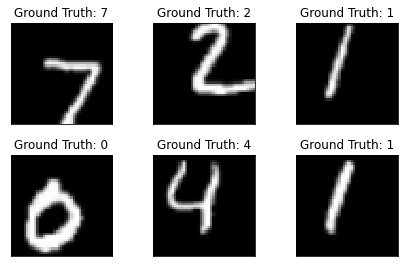

In [13]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [14]:
class ResNet(nn.Module):
    def __init__(self, num_layers, in_channels, output_dim, pretrained = True,freeze_pretrained=False):
        super().__init__()

        self.conv_layers = None
        self.fc_layers = None
        self.loss_criterion = None

        if num_layers == 18:
            resnet_model = models.resnet18(pretrained=pretrained)
        elif num_layers == 34:
            resnet_model = models.resnet34(pretrained=pretrained)
        if in_channels == 1:
            conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            if pretrained:
                conv1.weight = nn.Parameter(torch.mean(resnet_model.conv1.weight, dim=1, keepdim=True))
            resnet_model.conv1 = conv1
        self.conv_layers = nn.Sequential(*(list(resnet_model.children())[:-1]))
        self.fc_layers = nn.Sequential(torch.nn.Linear(list(resnet_model.children())[-1].in_features, output_dim))
        if freeze_pretrained:
            for param in self.conv_layers.parameters():
                param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        model_output = self.conv_layers(x)
        model_output = model_output.view(model_output.shape[0], -1)
        model_output = self.fc_layers(model_output)

        return model_output

In [15]:
class VGG16(nn.Module):
    def __init__(self, in_channels, output_dim):
        super().__init__()
        model = models.vgg16_bn()
        model.classifier = nn.Sequential(
            nn.Linear(in_features=model.classifier[0].in_features, out_features=100, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=100, out_features=output_dim, bias=True)
        )
        model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.model = model
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        model_output = self.model(x)

        return model_output

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, output_dim):
        super(SimpleCNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,16,5), # 16*24*24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5), # 32*20*20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2), # 32*10*10
            nn.Conv2d(32,64,5), # 64*6*6
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(576,100),
            nn.ReLU(),
            nn.Linear(100,output_dim)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(out.size(0),-1)
        out = self.fc_layer(out)

        return out

In [17]:
def plot_loss_history(train_loss_history, validation_loss_history):
        """Plots the loss history"""
        plt.figure()
        epoch_idxs = range(len(train_loss_history))

        plt.plot(epoch_idxs, train_loss_history, "-b", label="training")
        plt.plot(epoch_idxs, validation_loss_history, "-r", label="validation")
        plt.title("Loss history")
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.show()

def plot_accuracy(train_accuracy_history, validation_accuracy_history):
    """Plots the accuracy history"""
    plt.figure()
    epoch_idxs = range(len(train_accuracy_history))
    plt.plot(epoch_idxs, train_accuracy_history, "-b", label="training")
    plt.plot(epoch_idxs, validation_accuracy_history, "-r", label="validation")
    plt.title("Accuracy history")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.show()

In [18]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    loss_history= []
    acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_train_batches = len(dataloaders['train'])
    num_val_batches = len(dataloaders['val'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item()), end="")

                sys.stdout.flush()
                
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
            epoch_loss = running_loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        avg_loss = avg_loss / num_train_batches
        val_loss = val_loss/num_val_batches
        loss_history.append([avg_loss, val_loss])
        acc_history.append([t_acc, val_acc])
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size_test, shuffle=True)
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(val_dataset)
dataloaders={}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

In [20]:
if model_name == "vgg16":
    model = VGG16(1, num_classes)
elif model_name == "resnet18":
    model = ResNet(18, 1, num_classes, pretrained = False)
elif model_name == 'simpleCNN':
    model = SimpleCNN(1, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
model, loss_history, acc_history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, None,num_epochs=n_epochs)

Epoch 1/8
----------
Iteration: 79/79, Loss: 0.1774013340473175.Train Loss: 1.2707 Acc: 0.5097
Val Loss: 0.4637 Acc: 0.7827
Best Val Accuracy: 0.7827000000000001

Epoch 2/8
----------
Iteration: 79/79, Loss: 0.004717093426734209.Train Loss: 0.7010 Acc: 0.7208
Val Loss: 0.1259 Acc: 0.9798
Best Val Accuracy: 0.9798

Epoch 3/8
----------
Iteration: 79/79, Loss: 0.0066390736028552055.Train Loss: 0.4126 Acc: 0.8569
Val Loss: 0.1304 Acc: 0.9671
Best Val Accuracy: 0.9798

Epoch 4/8
----------
Iteration: 79/79, Loss: 1.5376692317659035e-05.Train Loss: 0.3381 Acc: 0.8787
Val Loss: 0.0505 Acc: 0.9901
Best Val Accuracy: 0.9901000000000001

Epoch 5/8
----------
Iteration: 79/79, Loss: 0.03083053044974804.Train Loss: 0.2346 Acc: 0.9181
Val Loss: 0.0654 Acc: 0.9852
Best Val Accuracy: 0.9901000000000001

Epoch 6/8
----------
Iteration: 79/79, Loss: 1.2732664799841587e-05.Train Loss: 0.1818 Acc: 0.9342
Val Loss: 0.0594 Acc: 0.9879
Best Val Accuracy: 0.9901000000000001

Epoch 7/8
----------
Iteration: 

In [22]:
torch.save(model.state_dict(), model_name + "_baseline.pt") 

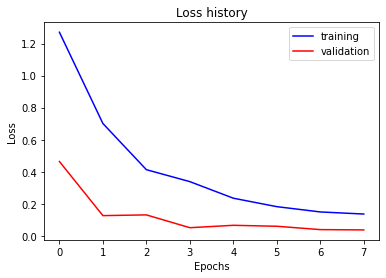

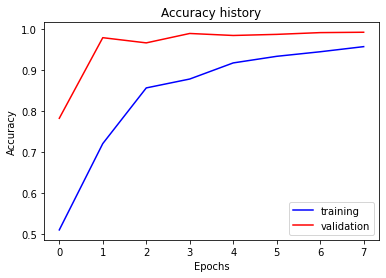

In [23]:
loss_history = pd.DataFrame(loss_history, columns=['train', 'val'])
acc_history = pd.DataFrame(acc_history, columns=['train', 'val'])
plot_loss_history(loss_history.loc[:, 'train'], loss_history.loc[:, 'val'])
plot_accuracy(acc_history.loc[:, 'train'], acc_history.loc[:, 'val'])

In [24]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.jit


class Tent(nn.Module):
    """Tent adapts a model by entropy minimization during testing.
    Once tented, a model adapts itself by updating on every forward.
    """
    def __init__(self, model, optimizer, steps=1, episodic=False):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.steps = steps
        assert steps > 0, "tent requires >= 1 step(s) to forward and update"
        self.episodic = episodic

        # note: if the model is never reset, like for continual adaptation,
        # then skipping the state copy would save memory
        self.model_state, self.optimizer_state = \
            copy_model_and_optimizer(self.model, self.optimizer)

    def forward(self, x):
        if self.episodic:
            self.reset()

        for _ in range(self.steps):
            outputs = forward_and_adapt(x, self.model, self.optimizer)

        return outputs

    def reset(self):
        if self.model_state is None or self.optimizer_state is None:
            raise Exception("cannot reset without saved model/optimizer state")
        load_model_and_optimizer(self.model, self.optimizer,
                                 self.model_state, self.optimizer_state)


@torch.jit.script
def softmax_entropy(x: torch.Tensor) -> torch.Tensor:
    """Entropy of softmax distribution from logits."""
    return -(x.softmax(1) * x.log_softmax(1)).sum(1)


@torch.enable_grad()  # ensure grads in possible no grad context for testing
def forward_and_adapt(x, model, optimizer):
    """Forward and adapt model on batch of data.
    Measure entropy of the model prediction, take gradients, and update params.
    """
    # forward
    outputs = model(x)
    # adapt
    loss = softmax_entropy(outputs).mean(0)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return outputs


def collect_params(model):
    """Collect the affine scale + shift parameters from batch norms.
    Walk the model's modules and collect all batch normalization parameters.
    Return the parameters and their names.
    Note: other choices of parameterization are possible!
    """
    params = []
    names = []
    for nm, m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            for np, p in m.named_parameters():
                if np in ['weight', 'bias']:  # weight is scale, bias is shift
                    params.append(p)
                    names.append(f"{nm}.{np}")
    return params, names


def copy_model_and_optimizer(model, optimizer):
    """Copy the model and optimizer states for resetting after adaptation."""
    model_state = deepcopy(model.state_dict())
    optimizer_state = deepcopy(optimizer.state_dict())
    return model_state, optimizer_state


def load_model_and_optimizer(model, optimizer, model_state, optimizer_state):
    """Restore the model and optimizer states from copies."""
    model.load_state_dict(model_state, strict=True)
    optimizer.load_state_dict(optimizer_state)


def configure_model(model):
    """Configure model for use with tent."""
    # train mode, because tent optimizes the model to minimize entropy
    model.train()
    # disable grad, to (re-)enable only what tent updates
    model.requires_grad_(False)
    # configure norm for tent updates: enable grad + force batch statisics
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.requires_grad_(True)
            # force use of batch stats in train and eval modes
            m.track_running_stats = False
            m.running_mean = None
            m.running_var = None
    return model


def check_model(model):
    """Check model for compatability with tent."""
    is_training = model.training
    assert is_training, "tent needs train mode: call model.train()"
    param_grads = [p.requires_grad for p in model.parameters()]
    has_any_params = any(param_grads)
    has_all_params = all(param_grads)
    assert has_any_params, "tent needs params to update: " \
                           "check which require grad"
    assert not has_all_params, "tent should not update all params: " \
                               "check which require grad"
    has_bn = any([isinstance(m, nn.BatchNorm2d) for m in model.modules()])
    assert has_bn, "tent needs normalization for its optimization"

In [25]:
if model_name == "vgg16":
    model = VGG16(1, num_classes)
elif model_name == "resnet18":
    model = ResNet(18, 1, num_classes, pretrained = False)
elif model_name == 'simpleCNN':
    model = SimpleCNN(1, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_name+"_baseline.pt"))
model = model.to(device)

In [26]:
print("Model: ", model_name)
print("###Test Set Accuracy on Clean Images with no TENT###")
model.eval()
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size_test, shuffle=False)
running_loss = 0.0
running_acc = 0.0


for i, batch in enumerate(test_loader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    loss = nn.CrossEntropyLoss(reduction='mean')(outputs, labels)

    _, preds = torch.max(outputs, 1)
    # y.append(labels.tolist())
    # yhat.append(preds.tolist())
    running_loss += loss.detach() * inputs.size(0)
    running_acc += torch.sum(preds == labels.data)

# Get loss and accuracy
test_loss = (running_loss / len(val_dataset))
test_accuracy = (running_acc.float() / len(val_dataset))

# Display loss, accuracy values after each epoch
print("Test loss: {:.4f} | Test acc.: {:.4f}\n"
            .format(test_loss.item(),test_accuracy.item()))

Model:  vgg16
###Test Set Accuracy on Clean Images with no TENT###
Test loss: 0.0370 | Test acc.: 0.9931



In [27]:
chal_labels = val_dataset.targets
testset_c_dir = 'mnist_c/'
challenges = os.listdir(testset_c_dir)
# print(challenges)
print("Model: ", model_name)
print("###Test Set Accuracy on Corrupted Images with no TENT###")

model.eval()
avg_list = []
for chal in challenges:
    chal_avg = 0
    for severity in range(1, 2):
        chal_data = np.load(testset_c_dir + chal + '/test_images.npy')
        chal_data = preprocess_test(chal_data, (0.1307,), (0.3081,),size)
        chal_dataset = torch.utils.data.TensorDataset(chal_data, chal_labels)
        test_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=batch_size_test)

        sev_acc = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                sev_acc += torch.sum(torch.argmax(outputs,1) == y)

        chal_avg += (sev_acc/len(chal_dataset)).item()
    
    avg_list.append(chal_avg)
    print(chal, ": ", (chal_avg)," ")

print("Mean: ", np.mean(avg_list))

Model:  vgg16
###Test Set Accuracy on Corrupted Images with no TENT###
canny_edges :  0.757099986076355  
brightness :  0.7687999606132507  
dotted_line :  0.9472999572753906  
fog :  0.5769999623298645  
identity :  0.9930999875068665  
spatter :  0.9563999772071838  
zigzag :  0.7866999506950378  
scale :  0.9672999978065491  
glass_blur :  0.9055999517440796  
impulse_noise :  0.8965999484062195  
stripe :  0.3511999845504761  
shot_noise :  0.9746999740600586  
rotate :  0.9664999842643738  
motion_blur :  0.9228000044822693  
shear :  0.9853000044822693  
translate :  0.9056999683380127  
Mean:  0.853881224989891


In [28]:
baseresults= list(zip(challenges, avg_list))
results = pd.DataFrame(baseresults, columns=['DistortionType', 'baseline_score'])
# model_base.to_csv(model_name+"_baseline.csv")

In [29]:
print("Model: ", model_name)
print("###Test Set Accuracy on Clean Images with TENT###")
if model_name == "vgg16":
    model = VGG16(1, num_classes)
elif model_name == "resnet18":
    model = ResNet(18, 1, num_classes, pretrained = False)
elif model_name == 'simpleCNN':
    model = SimpleCNN(1, num_classes)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_name+"_baseline.pt"))

net = configure_model(model)
params, param_names = collect_params(net)
optimizer = torch.optim.Adam(params, lr=1e-3)
tented_model = Tent(net, optimizer)

tented_model = tented_model.to(device)
tented_model.eval()
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size_test, shuffle=False)
running_loss = 0.0
running_acc = 0.0


for i, batch in enumerate(test_loader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad(): 
        outputs = tented_model(inputs)
    loss = nn.CrossEntropyLoss(reduction='mean')(outputs, labels)

    _, preds = torch.max(outputs, 1)
    running_loss += loss.detach() * inputs.size(0)
    running_acc += torch.sum(preds == labels.data)

# Get loss and accuracy
test_loss = (running_loss / len(val_dataset))
test_accuracy = (running_acc.float() / len(val_dataset))

# Display loss, accuracy values after each epoch
print("Test loss: {:.4f} | Test acc.: {:.4f}\n"
            .format(test_loss.item(),test_accuracy.item()))

Model:  vgg16
###Test Set Accuracy on Clean Images with TENT###
Test loss: 0.0371 | Test acc.: 0.9924



In [30]:
chal_labels = val_dataset.targets
testset_c_dir = 'mnist_c/'
challenges = os.listdir(testset_c_dir)
print("Model: ", model_name)
print("###Test Set Accuracy on Corrupted Images with TENT###")

model.eval()
avg_list = []
for chal in challenges:
    chal_avg = 0
    for severity in range(1, 2):
        if model_name == "vgg16":
            model = VGG16(1, num_classes)
        elif model_name == "resnet18":
            model = ResNet(18, 1, num_classes, pretrained = False)
        elif model_name == 'simpleCNN':
            model = SimpleCNN(1, num_classes)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(torch.load(model_name+"_baseline.pt"))
        
        net = configure_model(model)
        params, param_names = collect_params(net)
        optimizer = torch.optim.Adam(params, lr=1e-3)
        tented_model = Tent(net, optimizer)

        tented_model = tented_model.to(device)

        chal_data = np.load(testset_c_dir + chal + '/test_images.npy')
        chal_data = preprocess_test(chal_data, (0.1307,), (0.3081,), size)
        chal_dataset = torch.utils.data.TensorDataset(chal_data, chal_labels)
        test_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=batch_size_test)

        sev_acc = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                outputs = tented_model(x)
                sev_acc += torch.sum(torch.argmax(outputs,1) == y)

        chal_avg += (sev_acc/len(chal_dataset)).item()
    
    avg_list.append(chal_avg)
    print(chal, ": ", (chal_avg)," ")

print("Mean: ", np.mean(avg_list))

Model:  vgg16
###Test Set Accuracy on Corrupted Images with TENT###
canny_edges :  0.8748999834060669  
brightness :  0.9651999473571777  
dotted_line :  0.9472999572753906  
fog :  0.8779999613761902  
identity :  0.9656999707221985  
spatter :  0.9449999928474426  
zigzag :  0.8273999691009521  
scale :  0.943399965763092  
glass_blur :  0.9211999773979187  
impulse_noise :  0.9398999810218811  
stripe :  0.8453999757766724  
shot_noise :  0.9591999650001526  
rotate :  0.9472999572753906  
motion_blur :  0.9449999928474426  
shear :  0.9611999988555908  
translate :  0.8804999589920044  
Mean:  0.9216624721884727


In [31]:
results["tent_score"] = avg_list
results.to_csv(model_name+'_results.csv')
results = results.set_index('DistortionType')

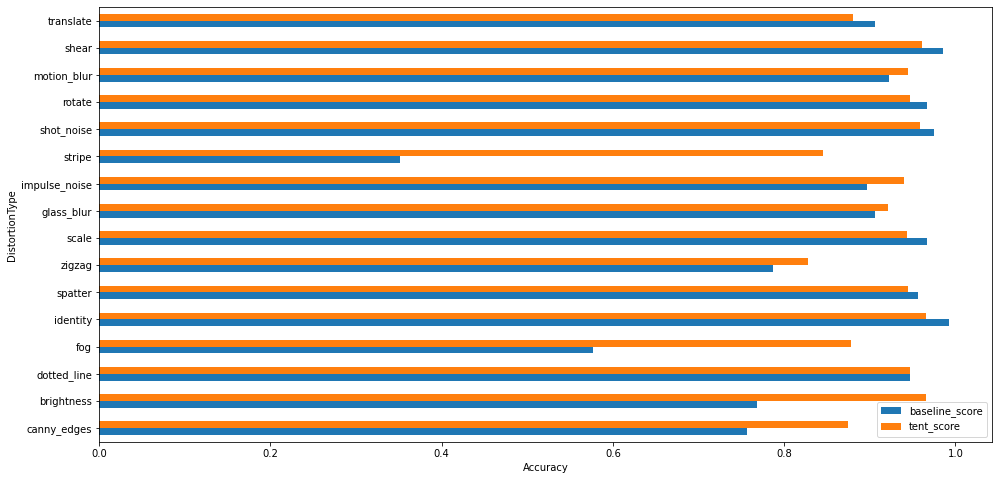

In [32]:
ax = results.plot.barh(figsize=(16,8))
ax.set_xlabel("Accuracy")
plt.savefig("mnistc_" + model_name +".pdf",bbox_inches = "tight")